# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
# !pip install ipywidgets

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
#Determine the mean and std of MNIST data:
# Define the data transformation
transform = torchvision.transforms.ToTensor()

# Download the MNIST training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Create a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

# Accumulate pixel values
pixel_sum = 0.0
pixel_squared_sum = 0.0
num_pixels = 0

for images, _ in train_loader:
    batch_sum = torch.sum(images)
    batch_squared_sum = torch.sum(images ** 2)
    batch_num_pixels = images.numel()

    pixel_sum += batch_sum
    pixel_squared_sum += batch_squared_sum
    num_pixels += batch_num_pixels

# Compute mean and standard deviation
mean = pixel_sum / num_pixels
std = torch.sqrt(pixel_squared_sum / num_pixels - mean ** 2)

# Convert mean and std to numpy arrays
mean = mean.numpy()
std = std.numpy()

print("Mean:", mean)
print("Standard Deviation:", std)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Mean: 0.13066049
Standard Deviation: 0.3081077


In [6]:
#Determine the mean and std of MNIST data:
# Define the data transformation
transform = torchvision.transforms.ToTensor()

# Download the MNIST training dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create a data loader for the training dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Accumulate pixel values
pixel_sum = 0.0
pixel_squared_sum = 0.0
num_pixels = 0

for images, _ in test_loader:
    batch_sum = torch.sum(images)
    batch_squared_sum = torch.sum(images ** 2)
    batch_num_pixels = images.numel()

    pixel_sum += batch_sum
    pixel_squared_sum += batch_squared_sum
    num_pixels += batch_num_pixels

# Compute mean and standard deviation
mean = pixel_sum / num_pixels
std = torch.sqrt(pixel_squared_sum / num_pixels - mean ** 2)

# Convert mean and std to numpy arrays
mean = mean.numpy()
std = std.numpy()

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: 0.13251474
Standard Deviation: 0.3104801


In [7]:
# !pip install albumentations

In [8]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.13066049), (0.3081077))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13251474), (0.3104801))
    
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I have tried RandAugment and Colorjitter first. They failed, mainly because the MNIST consists of grayscale images, and adjusting the brightness, contrast, and other factors is not a good idea in this case since there is only one channel of images. The CNN architecture had trouble finding a global minimum due to the changing image content. Applying color jitter to colored images seems like a better way than doing it to grayscale. RandAugment fails because of the same principle. Some random transforming techniques can be applied, including color jitter in random, which would result in worse performance than not using them. Instead of augment and color jitter, I decided to go with horizontal and vertical flips, as well as rotations, so that they can be more easily recognized if the algorithm is subjected to such images.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


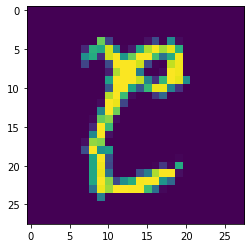

5


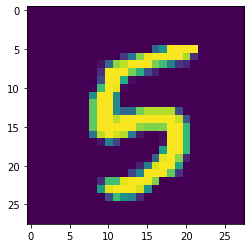

5


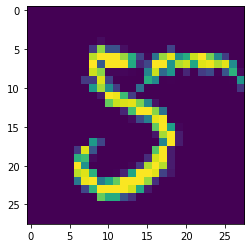

9


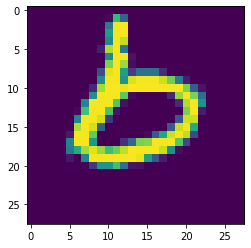

4


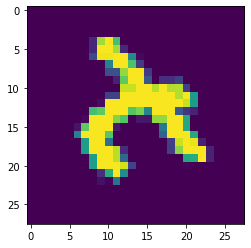

In [10]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [11]:
## YOUR CODE HERE ##

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*5*5, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(84, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = Model()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

model = Model()    
model.to(device)
print(model)

Model(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1600, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_fe

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [14]:
## YOUR CODE HERE ##
epochs = 10 

train_losses = []
test_losses = []

for epoch in range(epochs):
    
    model.train()
    train_loss = 0
    model.to(device)
    for idx, (images, labels) in enumerate(train_loader): 

        
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in test_loader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels).item()

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(train_loader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(test_loader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(test_loader)))

Epoch: 1/10   Training loss: 1.6863   Testing loss: 1.5318   Test accuracy: 0.9306  
Epoch: 2/10   Training loss: 1.5879   Testing loss: 1.5286   Test accuracy: 0.9322  
Epoch: 3/10   Training loss: 1.5714   Testing loss: 1.5140   Test accuracy: 0.9473  
Epoch: 4/10   Training loss: 1.5606   Testing loss: 1.5105   Test accuracy: 0.9507  
Epoch: 5/10   Training loss: 1.5543   Testing loss: 1.5010   Test accuracy: 0.9604  
Epoch: 6/10   Training loss: 1.5490   Testing loss: 1.5079   Test accuracy: 0.9527  
Epoch: 7/10   Training loss: 1.5461   Testing loss: 1.5079   Test accuracy: 0.9531  
Epoch: 8/10   Training loss: 1.5416   Testing loss: 1.5100   Test accuracy: 0.9515  
Epoch: 9/10   Training loss: 1.5401   Testing loss: 1.5074   Test accuracy: 0.9532  
Epoch: 10/10   Training loss: 1.5366   Testing loss: 1.5046   Test accuracy: 0.9565  


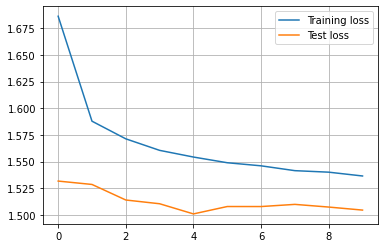

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()
     

Plot the training loss (and validation loss/accuracy, if recorded).

[0.08533674 0.23196931 0.08533674 0.08533674 0.08533674 0.08533674
 0.08533674 0.08533674 0.08533674 0.08533674]


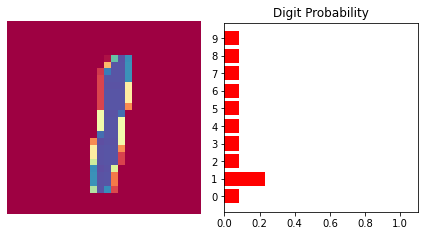

In [17]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='Spectral')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='b' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Digit Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [38]:
## YOUR CODE HERE ##
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.10),
            
            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.10)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*5*5, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(256, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(84, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = Model2()

In [39]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

model = Model2()    
model.to(device)
print(model)

Model2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.1, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [40]:
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [41]:
## YOUR CODE HERE ##
epochs = 10 

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    model.to(device)
    for idx, (images, labels) in enumerate(train_loader): 

        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in test_loader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels).item()

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(train_loader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(test_loader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(test_loader)))

Epoch: 1/10   Training loss: 1.6739   Testing loss: 1.5546   Test accuracy: 0.9061  
Epoch: 2/10   Training loss: 1.5803   Testing loss: 1.5271   Test accuracy: 0.9350  
Epoch: 3/10   Training loss: 1.5639   Testing loss: 1.5089   Test accuracy: 0.9523  
Epoch: 4/10   Training loss: 1.5554   Testing loss: 1.5282   Test accuracy: 0.9331  
Epoch: 5/10   Training loss: 1.5515   Testing loss: 1.5084   Test accuracy: 0.9527  
Epoch: 6/10   Training loss: 1.5449   Testing loss: 1.5096   Test accuracy: 0.9513  
Epoch: 7/10   Training loss: 1.5428   Testing loss: 1.5015   Test accuracy: 0.9597  
Epoch: 8/10   Training loss: 1.5393   Testing loss: 1.5029   Test accuracy: 0.9580  
Epoch: 9/10   Training loss: 1.5351   Testing loss: 1.4979   Test accuracy: 0.9632  
Epoch: 10/10   Training loss: 1.5318   Testing loss: 1.4955   Test accuracy: 0.9661  


## Saving your model
Using `torch.save`, save your model for future loading.

In [43]:
## YOUR CODE HERE ##
checkpoint = {'input_size': 784,
              'output_size': 10,
              'arch': 'CNN_Architecture',
              
              'learning_rate': 0.003,
              'epochs': 10,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
             }

torch.save(checkpoint, 'checkpoint_CNN_Architecture.pth')